# **Classification Objective**
## 🎯 Objective:
### In this project, the objective is to classify stocks based on their status (Recovery/Soon to be Recovered/Available).

## Importation de Data (SSMS)

In [44]:
import pyodbc
import pandas as pd

# Connexion à la base de données SQL Server
conn = pyodbc.connect(
    'DRIVER={SQL Server};'
    'SERVER=DESKTOP-STG70TI\\SQLSERVER;'  # Remplacez par votre serveur SQL
    'DATABASE=DW_SAP_Co2;'  # Remplacez par votre base de données
    'Trusted_Connection=yes;'
)

# Requête SQL pour faire les jointures entre les tables
query = """
SELECT
    F.[Total_Stock],
    F.[Input_stock],
    F.[Output_Stock],
   
  
    D.[FullDate],
    D.[Day],
    D.[Month],
    D.[Year],
    S.[Supplier_Name]
FROM [DW_SAP_Co2].[dbo].[Fact_MM_PM] F
JOIN [DW_SAP_Co2].[dbo].[Dim_Material] M
    ON F.Fk_Material = M.Pk_Material
JOIN [DW_SAP_Co2].[dbo].[Fact_Co2_Emissions] COE
    ON M.Pk_Material = COE.Fk_Material
JOIN [DW_SAP_Co2].[dbo].[Dim_Date] D
    ON COE.Fk_Date = D.Pk_Date
JOIN [DW_SAP_Co2].[dbo].[Dim_Supplier] S
    ON COE.Fk_Supplier = S.Pk_Supplier
"""

# Exécution de la requête SQL
df = pd.read_sql(query, conn)

# Affichage des résultats sans doublons
print(df.head())
# Fermeture de la connexion
conn.close()


C:\Users\DELL\AppData\Local\Temp\ipykernel_12816\3746600890.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


   Total_Stock  Input_stock  Output_Stock    FullDate Day Month  Year  \
0        593.0           49             6  2024-07-09  09    07  2024   
1        593.0           49             6  2024-07-09  09    07  2024   
2        593.0           49             6  2024-07-09  09    07  2024   
3        593.0           49             6  2024-07-09  09    07  2024   
4        593.0           49             6  2024-07-09  09    07  2024   

            Supplier_Name  
0  Fournitures Voie Verte  
1  Fournitures Voie Verte  
2  Fournitures Voie Verte  
3  Fournitures Voie Verte  
4  Fournitures Voie Verte  


## Remove duplicators

In [45]:
df_cleaned = df.drop_duplicates()
print(df_cleaned.head())

    Total_Stock  Input_stock  Output_Stock    FullDate Day Month  Year  \
0         593.0           49             6  2024-07-09  09    07  2024   
6         546.0           18             6  2024-07-09  09    07  2024   
12        961.0           37            19  2024-07-09  09    07  2024   
18        908.0           34            18  2024-07-09  09    07  2024   
24        711.0           27             0  2024-07-09  09    07  2024   

             Supplier_Name  
0   Fournitures Voie Verte  
6   Fournitures Voie Verte  
12  Fournitures Voie Verte  
18  Fournitures Voie Verte  
24  Fournitures Voie Verte  


## Data preparation

In [46]:

# Calcul de la colonne 'Stock_Actual'
df_cleaned['Stock_Actual'] = df_cleaned['Total_Stock'] + df_cleaned['Input_stock'] - df_cleaned['Output_Stock']

# Affichage des résultats avec la nouvelle colonne 'Stock_Actual'
print(df_cleaned[['Total_Stock', 'Input_stock', 'Output_Stock', 'Stock_Actual']].head())


    Total_Stock  Input_stock  Output_Stock  Stock_Actual
0         593.0           49             6         636.0
6         546.0           18             6         558.0
12        961.0           37            19         979.0
18        908.0           34            18         924.0
24        711.0           27             0         738.0


C:\Users\DELL\AppData\Local\Temp\ipykernel_12816\2696874670.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Stock_Actual'] = df_cleaned['Total_Stock'] + df_cleaned['Input_stock'] - df_cleaned['Output_Stock']


# **Models**

# Classification Function

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


def classify_stock(stock):
    if stock <= 0:
        return 'Out of stock'
    elif 0 < stock < 20:
        return 'Stock will be sold out soon'
    else:
        return 'Stock available'

# Appliquer la fonction de classification sur la colonne 'Stock_Actual'
df_cleaned['Stock_Status'] = df_cleaned['Stock_Actual'].apply(classify_stock)

# Convertir les labels en valeurs numériques
df_cleaned['Stock_Status_Label'] = df_cleaned['Stock_Status'].map({
    'Out of stock': 0,
    'Stock will be sold out soon': 1,
    'Stock available': 2
})

# Séparer les features (X) et la cible (y)
X = df_cleaned[['Total_Stock', 'Input_stock', 'Output_Stock']]  # Features
y = df_cleaned['Stock_Status_Label']  # Target


C:\Users\DELL\AppData\Local\Temp\ipykernel_12816\1172503246.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Stock_Status'] = df_cleaned['Stock_Actual'].apply(classify_stock)
C:\Users\DELL\AppData\Local\Temp\ipykernel_12816\1172503246.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Stock_Status_Label'] = df_cleaned['Stock_Status'].map({


# **Random Forest Classifier Model**
#### The Random Forest Classifier is robust and accurate, reducing the risk of overfitting. It efficiently handles missing and noisy data without requiring complex preprocessing. This model offers excellent ability to assess variable importance and works well with multiclass data. Easy to use, it provides reliable predictions with good results right from the start.

## Split the Train and Test data

In [48]:
#(80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Create a classification model (Random Forest) Train the model

In [49]:

model = RandomForestClassifier(n_estimators=100, random_state=42)


model.fit(X_train, y_train)

# Prédictions sur le jeu de test
y_pred = model.predict(X_test)


## Metrics

In [50]:
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.00      0.00      0.00         1
           2       0.92      1.00      0.96        49

    accuracy                           0.93        54
   macro avg       0.64      0.42      0.45        54
weighted avg       0.91      0.93      0.90        54

Accuracy Score: 0.9259259259259259


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **Gradient Boosting Classifier Model**
#### The Gradient Boosting Classifier combines multiple decision trees to correct errors and gradually improve accuracy. It excels on complex and nonlinear data, delivering highly accurate results. However, it can be sensitive to noise and requires fine-tuning of hyperparameters to avoid overfitting.

## Create a model and train it

In [52]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score


gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)


gb_model.fit(X_train, y_train)

# Prédictions sur le jeu de test
y_pred_gb = gb_model.predict(X_test)


## Metrics

In [53]:

# Évaluation du modèle
print("Classification Report (Gradient Boosting):")
print(classification_report(y_test, y_pred_gb))
print("Accuracy Score (Gradient Boosting):", accuracy_score(y_test, y_pred_gb))


Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.00      0.00      0.00         1
           2       0.96      1.00      0.98        49

    accuracy                           0.96        54
   macro avg       0.65      0.58      0.61        54
weighted avg       0.95      0.96      0.95        54

Accuracy Score (Gradient Boosting): 0.9629629629629629


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **Naive Bayes Model**
#### Naive Bayes is a probabilistic classification model based on the assumption of feature independence. It is fast, simple, and effective for data where the relationships between variables are assumed to be independent. Although it is generally less complex, it can provide good results, especially for datasets with well-separated classes.

## Create a model and train it

In [54]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score


nb_model = GaussianNB()


nb_model.fit(X_train, y_train)

# Prédictions sur le jeu de test
y_pred_nb = nb_model.predict(X_test)



## Metrics

In [55]:
# Évaluation du modèle
print("Classification Report (Naive Bayes):")
print(classification_report(y_test, y_pred_nb))
print("Accuracy Score (Naive Bayes):", accuracy_score(y_test, y_pred_nb))


Classification Report (Naive Bayes):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         1
           2       0.91      1.00      0.95        49

    accuracy                           0.91        54
   macro avg       0.30      0.33      0.32        54
weighted avg       0.82      0.91      0.86        54

Accuracy Score (Naive Bayes): 0.9074074074074074


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **Conclusion and Comparison between models**

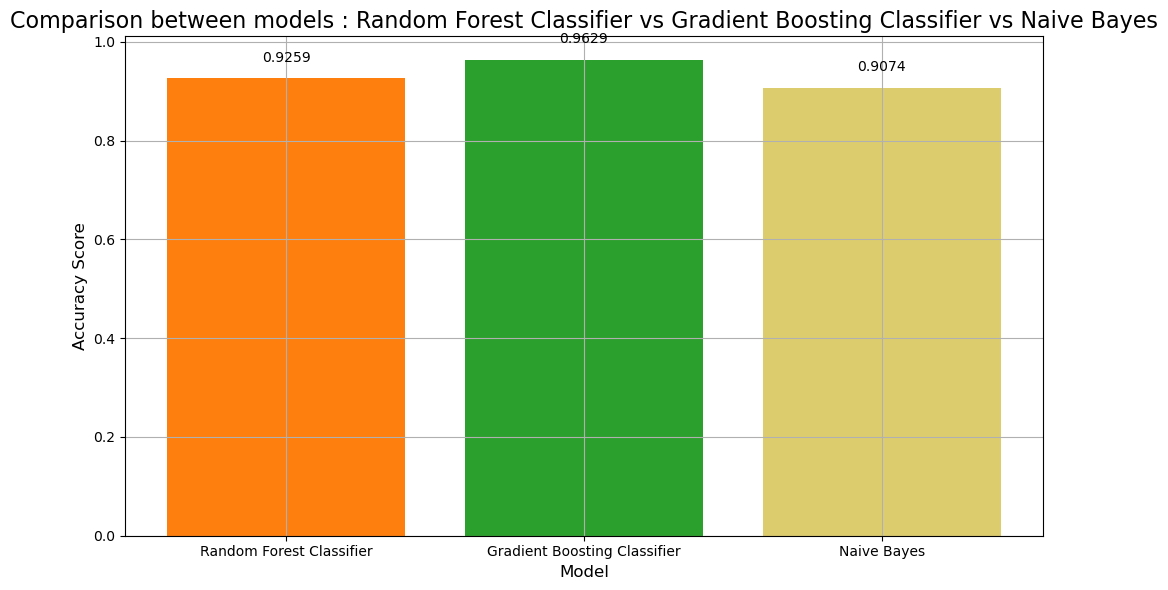

In [65]:
import matplotlib.pyplot as plt
import pandas as pd

# 📊 Données complètes des métriques
results = {
    "Random Forest Classifier": [0.9259],
    "Gradient Boosting Classifier": [0.9629],
    "Naive Bayes": [0.9074]
}

# 🧱 Créer le DataFrame
df_scores = pd.DataFrame(
    results, 
    index=["Accuracy Score"]
).T

# 📈 Création des barplots
fig, ax = plt.subplots(figsize=(10, 6))  # Un seul graphique

colors = ["#ff7f0e", "#2ca02c", "#ddcc6d"]

bars = ax.bar(df_scores.index, df_scores["Accuracy Score"], color=colors)

# Ajouter le titre, labels, etc.
ax.set_title("Comparison between models : Random Forest Classifier vs Gradient Boosting Classifier vs Naive Bayes", fontsize=16)
ax.set_ylabel("Accuracy Score", fontsize=12)
ax.set_xlabel("Model", fontsize=12)
ax.tick_params(axis='x', rotation=0)

# Ajouter les valeurs au-dessus des barres
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + abs(height)*0.03,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10)

# Afficher la grille et ajuster la mise en page
ax.grid(True)
plt.tight_layout()
plt.show()


# **Conclusion**
### The visualization above compares the accuracy scores of three classification models: Random Forest Classifier, Gradient Boosting Classifier, and Naive Bayes. The Gradient Boosting Classifier shows the best performance with a score of 0.9629, followed by the Random Forest Classifier at 0.9259. Naive Bayes achieves a slightly lower score of 0.9074.
### This comparison highlights the effectiveness of Gradient Boosting for classification in this context, while demonstrating that the other two models also perform well.